# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [4]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer1 = DenseLayer(num_features, n_hidden_1, name= "layer1")
    # Другий шар, який складається з 256 нейронів
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2, name = "layer2")
    # Вихідний шар
    self.out_layer = DenseLayer(n_hidden_2, num_classes, name = "out_layer")


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer1(x, activation = 1)
    x = self.layer2(x, activation = 1)
    x = self.out_layer(x, activation = 1)


    return x

In [5]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    if len(y_true.shape) == 2:
      y_true = tf.argmax(y_true, axis = 1)
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [6]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables
    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [7]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss)
        accuracy_history.append(acc)
        print(f"Step: {step}, Loss: {loss}, Accuracy: {acc}")

Step: 100, Loss: 588.4180297851562, Accuracy: 0.09765625
Step: 200, Loss: 586.2864990234375, Accuracy: 0.14453125
Step: 300, Loss: 587.794189453125, Accuracy: 0.13671875
Step: 400, Loss: 584.6702270507812, Accuracy: 0.17578125
Step: 500, Loss: 581.371337890625, Accuracy: 0.20703125
Step: 600, Loss: 572.5922241210938, Accuracy: 0.203125
Step: 700, Loss: 562.7021484375, Accuracy: 0.2109375
Step: 800, Loss: 556.7200927734375, Accuracy: 0.1796875
Step: 900, Loss: 541.6535034179688, Accuracy: 0.2109375
Step: 1000, Loss: 520.296142578125, Accuracy: 0.22265625
Step: 1100, Loss: 522.7711181640625, Accuracy: 0.203125
Step: 1200, Loss: 490.5642395019531, Accuracy: 0.33984375
Step: 1300, Loss: 481.1783752441406, Accuracy: 0.32421875
Step: 1400, Loss: 485.09112548828125, Accuracy: 0.34765625
Step: 1500, Loss: 477.46710205078125, Accuracy: 0.35546875
Step: 1600, Loss: 485.473388671875, Accuracy: 0.328125
Step: 1700, Loss: 469.4322814941406, Accuracy: 0.359375
Step: 1800, Loss: 470.9649963378906, Ac

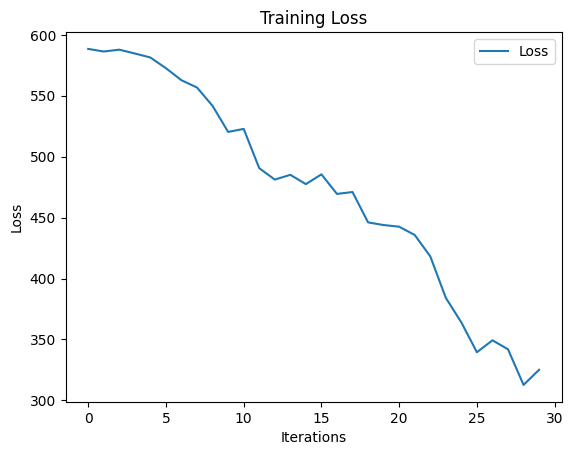

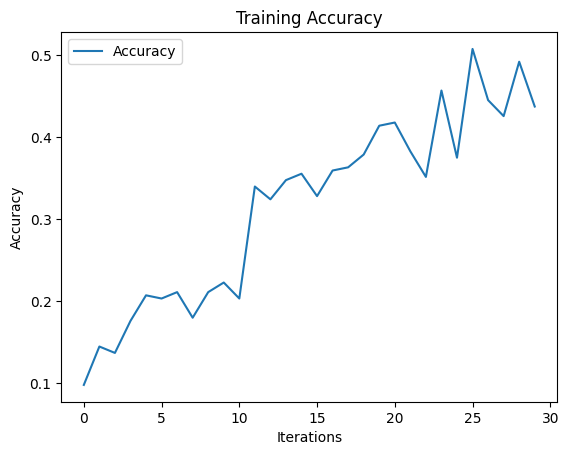

In [8]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.plot(loss_history, label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


# Виведіть графік точності
plt.plot(accuracy_history, label='Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

In [9]:
# Обчисліть точність навченої нейромережі

# Тестування моделі на тестових даних
test_pred = neural_net(x_test)
test_acc = accuracy(test_pred, y_test)
print(f"Test Accuracy: {test_acc}")

Test Accuracy: 0.4794999957084656


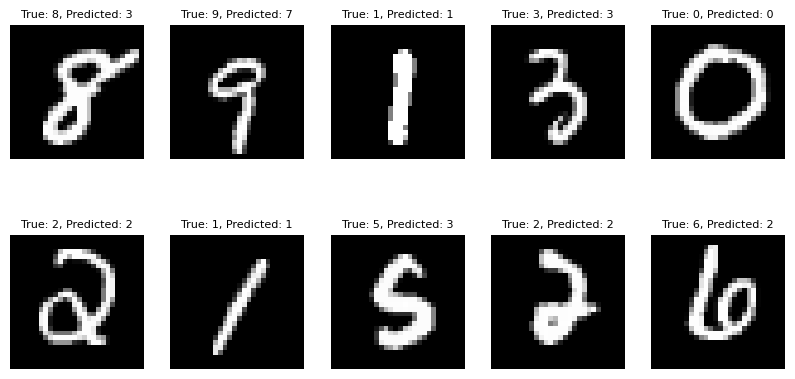

In [10]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

num_test_images = 10
random_indices = np.random.choice(len(x_test), num_test_images, replace=False)
test_images = x_test[random_indices]
test_labels = y_test[random_indices]

predictions = neural_net(test_images)
predicted_labels = tf.argmax(predictions, axis=1)

plt.figure(figsize=(10, 5))
for i in range(num_test_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(np.reshape(test_images[i], (28, 28)), cmap='gray')
    plt.title(f"True: {test_labels[i]}, Predicted: {predicted_labels[i]}", fontsize=8)
    plt.axis('off')
plt.show()

In [11]:
#Метрики якості для кожного класу навченої моделі, використовуючи https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
from sklearn.metrics import classification_report

predicted_classes = tf.argmax(neural_net(x_test), axis=1)

print(classification_report(y_test, predicted_classes, zero_division='warn'))


              precision    recall  f1-score   support

           0       0.76      0.91      0.83       980
           1       0.92      0.93      0.93      1135
           2       0.42      0.80      0.55      1032
           3       0.40      0.84      0.54      1010
           4       0.11      0.00      0.01       982
           5       0.77      0.12      0.21       892
           6       0.11      0.00      0.00       958
           7       0.31      0.93      0.47      1028
           8       0.29      0.10      0.15       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.48     10000
   macro avg       0.41      0.46      0.37     10000
weighted avg       0.41      0.48      0.38     10000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
from sklearn.model_selection import KFold

n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True)

accuracy_scores = []

for train_index, val_index in kf.split(x_train):
    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]


    learning_rates = [0.0001, 0.001, 0.01, 0.1]

    for lr in learning_rates:
        neural_net = NN(name="mnist")
        train(neural_net, x_train_fold, y_train_fold)


        predictions = neural_net(x_val_fold)
        predicted_labels = tf.argmax(predictions, axis=1)
        accuracy = np.mean(predicted_labels.numpy() == y_val_fold)
        print(f"Validation Accuracy (learning_rate={lr}): {accuracy}")


        accuracy_scores.append((lr, accuracy))


for lr, accuracy in accuracy_scores:
    print(f"Learning Rate: {lr}, Accuracy: {accuracy}")

best_learning_rate, best_accuracy = max(accuracy_scores, key=lambda x: x[1])
print(f"Best Learning Rate: {best_learning_rate}, Best Accuracy: {best_accuracy}")

Validation Accuracy (learning_rate=0.0001): 0.11691666666666667
Validation Accuracy (learning_rate=0.001): 0.11208333333333333
Validation Accuracy (learning_rate=0.01): 0.13566666666666666
Validation Accuracy (learning_rate=0.1): 0.11208333333333333
Validation Accuracy (learning_rate=0.0001): 0.14791666666666667
Validation Accuracy (learning_rate=0.001): 0.11
Validation Accuracy (learning_rate=0.01): 0.11933333333333333
Validation Accuracy (learning_rate=0.1): 0.12591666666666668
Validation Accuracy (learning_rate=0.0001): 0.11375
Validation Accuracy (learning_rate=0.001): 0.11366666666666667
Validation Accuracy (learning_rate=0.01): 0.11366666666666667
Validation Accuracy (learning_rate=0.1): 0.10216666666666667
Validation Accuracy (learning_rate=0.0001): 0.11216666666666666
Validation Accuracy (learning_rate=0.001): 0.11216666666666666
Validation Accuracy (learning_rate=0.01): 0.11216666666666666
Validation Accuracy (learning_rate=0.1): 0.11225
Validation Accuracy (learning_rate=0.00